In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
my_data=pd.read_excel('OnlineRetail.xlsx')

In [2]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
my_data.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
my_data.isna().any()


InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [7]:
my_data = my_data[pd.notnull(my_data['CustomerID'])]
my_data.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

In [9]:
my_data.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [10]:
my_data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
my_data = my_data[my_data.Quantity >= 0]
my_data.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


### Clustering

Starting RFM
Using RFM to cluster our customers? Let’s to it now. But first, why not talking a little bit about this approach?
According to Wikipedia, RFM stands for the three dimensions:
Recency — How recently did the customer purchase?
Frequency — How often do they purchase?
Monetary Value — How much do they spend?
One thing we can do with RFM is to assign a score for each dimension on a scale from 1 to 5, being 5 the most desired behavior. We’ll calculate the score later. We first need to create a new data frame composed by the recency, the frequency and the monetary value.
To calculate recency, we’ll look into the invoice dates. Since the date of our last invoice was 2011–12–09, we’ll consider it as the most recent one. Then, we’ll subtract each day from the day after to calculate the other ‘recencies’.
To calculate frequency, we’ll simply sum the invoice numbers for each customer. For the monetary value, we will multiply the unitary price by the quantity bought and sum them for each client.

In [13]:
import datetime as dt

print('Most recent invoice is from:')
print(my_data['InvoiceDate'].max())

lastDate = dt.datetime(2011,12,10)
my_data['InvoiceDate'] = pd.to_datetime(my_data['InvoiceDate'])

Most recent invoice is from:
2011-12-09 12:50:00


In [14]:
my_data['TotalPrice'] = my_data.UnitPrice * my_data.Quantity

In [15]:
rfmTable = my_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (lastDate - x.max()).days, 
                                           'InvoiceNo': lambda x: len(x), 
                                           'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary'}, inplace=True)

rfmTable.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


Now, we have to calculate the scores. We do it in the following way: first, we order the data by frequency in descending mode. Then, we divide the number of customers on the data set by 5. We assign a number from 5 to 1 to each one of the previously created segments. Let’s do it to ‘monetary’ and ‘recency’ columns too.
Attention: for the ‘recency’ column, since the most recent orders are better, we will order it as ascending.
I will add the scores to a new dataset called rfmTableScores.

In [16]:
# Create f_score

f_score = []
m_score = []
r_score = []

columns = ['frequency', 'monetary']
scores_str = ['f_score', 'm_score']
scores = [f_score, m_score]

for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(1,4340)
    rfmTable['refs'] = refs
    
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= 866:
            scores[n].append(5)
        elif row['refs'] > 866 and row['refs'] <= 866*2:
            scores[n].append(4)
        elif row['refs'] > 866*2 and row['refs'] <= 866*3:
            scores[n].append(3)
        elif row['refs'] > 866*3 and row['refs'] <= 866*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]
    
# For recency, we do the opposite: most recents are better, so we order as ascending
rfmTable = rfmTable.sort_values('recency', ascending=True)
    
# Recreate index
refs = np.arange(1,4340)
rfmTable['refs'] = refs
    
# Add score
for i, row in rfmTable.iterrows():
    if row['refs'] <= 866:
        r_score.append(5)
    elif row['refs'] > 866 and row['refs'] <= 866*2:
        r_score.append(4)
    elif row['refs'] > 866*2 and row['refs'] <= 866*3:
        r_score.append(3)
    elif row['refs'] > 866*3 and row['refs'] <= 866*4:
        r_score.append(2)
    else: 
        r_score.append(1)

# Create f_score column
rfmTable['r_score'] = r_score
    
rfmTableScores = rfmTable.drop(['frequency', 'monetary', 'recency', 'refs'], axis=1)

rfmTableScores.head(5)

,f_score,m_score,r_score
CustomerID,,,
13426.0,5,5,5
12423.0,5,4,5
12518.0,5,4,5
17389.0,5,5,5
14446.0,5,4,5


Since we have scores between 1 and 5, we don’t need to scale the numbers.
We can start to think about the model now. The K-Means model is only capable to cluster the information you have on your data set, but it’s you who has to choose how many clusters you want. You can use the K-Means model itself to make this decision. For this, let’s create the within-cluster sums of squares (WCSS) to support our decision.

In [17]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfmTableScores)
    wcss.append(kmeans.inertia_)

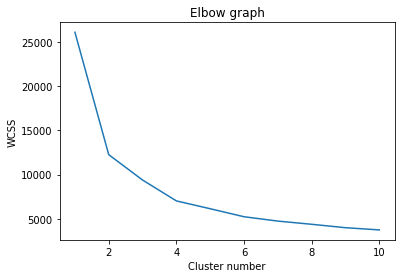

In [18]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfmTableScores)

In [20]:
rfmTable['clusters'] = clusters
rfmTable.head()

,recency,frequency,monetary,refs,f_score,m_score,r_score,clusters
CustomerID,,,,,,,,
13426.0,0,157,3641.32,1,5,5,5,2
12423.0,0,125,1859.31,2,5,4,5,2
12518.0,0,124,2056.89,3,5,4,5,2
17389.0,0,213,31833.68,4,5,5,5,2
14446.0,0,293,1039.58,5,5,4,5,2


We have finished the clustering process. That’s it. As you can see, the clusters were assigned to each customer thanks to the R, F and M scores analysis.
Just so you can see what we did, let’s plot a graph showing the data points before the clustering process and also some plots of after the clustering process. So you can clearly see the clusters formed.

Text(0.5, 0, 'Monetary')

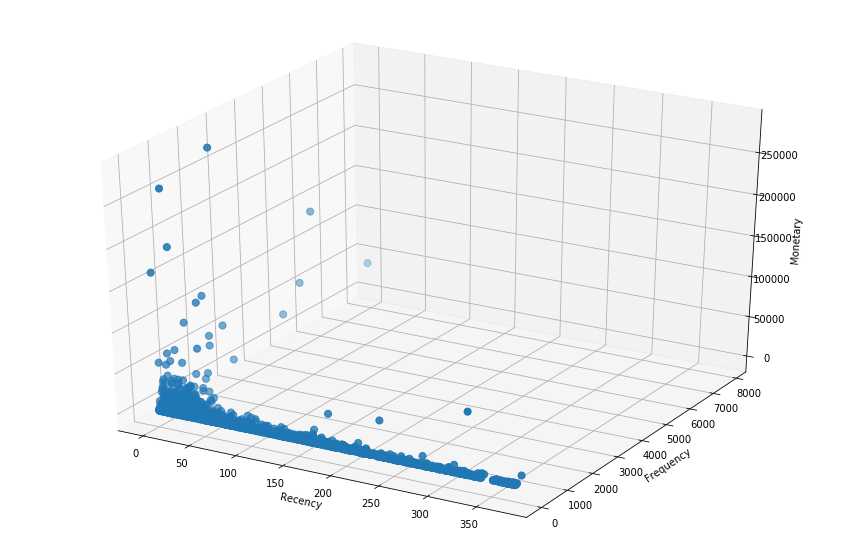

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfmTable.recency, rfmTable.frequency, rfmTable.monetary, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')